# Analyze data

## Import and merge data

In [1]:
import pandas as pd

In [2]:
# Metadata from Citations
metadata_raw = pd.read_csv("../data/raw/literature_review_meta_data.csv")

In [3]:
metadata_columns_include = ["Item Type", "Publication Year", "Author", "Title", "Publication Title", "Publisher",
                            "Place", "Editor", "Conference Name"]

In [4]:
metadata = metadata_raw[metadata_columns_include]

In [5]:
# Coding results from literature
data_raw = pd.read_excel("../data/raw/literature_coding_results.xlsx")

In [6]:
# Merge data
data = pd.merge(metadata, data_raw, how = "left", left_on='Title', right_on='article_name')

## Analyze metadata

### Type of Article

In [7]:
data.groupby("Item Type").size()

Item Type
conferencePaper     2
journalArticle     84
dtype: int64

In [8]:
data.groupby("survey_data").size()

survey_data
0.0     7
1.0    74
dtype: int64

### Graphic Publication per Year

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Prepare dataset
subset_year_category = data[["Publication Year", "article_topic"]]
subset_year = data[["Publication Year"]]
subset_year["article_topic"] = "All Publication"
visualization_year_category = subset_year_category.append(subset_year).sort_values("article_topic").reset_index(drop = True).dropna()

/var/folders/zx/r0fw_tq95g13lvmt5x8bp_vr0000gn/T/ipykernel_75796/4168712211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_year["article_topic"] = "All Publication"


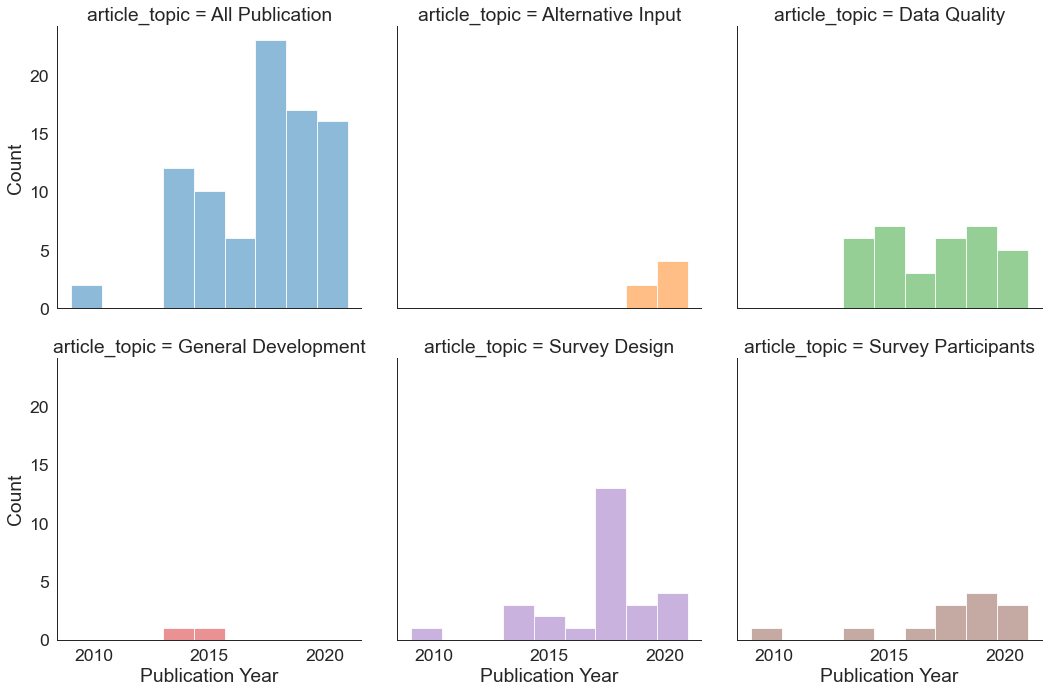

In [11]:
sns.set_style('white')
sns.set_context('paper', font_scale = 2)
plot = sns.displot(data=visualization_year_category, x= "Publication Year",
            hue="article_topic", col = "article_topic", col_wrap=3,legend = False
           )
plot.savefig('../reports/figures/publications_per_year_per_categories.png')

### Graphic Survey per Year

In [12]:
data_survey_year = data[data.survey_year.notna()]

In [13]:
7/73

0.0958904109589041

In [14]:
data_survey_year.groupby("survey_year").size()

survey_year
2005.0     1
2007.0     1
2010.0     1
2011.0     3
2012.0     6
2013.0     8
2014.0     7
2015.0    11
2016.0     8
2017.0     9
2018.0     6
2019.0     1
dtype: int64

In [15]:
data_survey_year.survey_year.mean()

2014.5483870967741

In [16]:
data_survey_year.groupby("Publication Year").size()

Publication Year
2009     1
2010     1
2013     3
2014     6
2015     5
2016     4
2017     6
2018     8
2019    13
2020     7
2021     8
dtype: int64

In [17]:
data_survey_year["Publication Year"].mean()

2017.4516129032259

In [18]:
data_survey_year["Publication Year"].mean()-data_survey_year.survey_year.mean()

2.903225806451701

### Overview of Journal

In [19]:
data.groupby("Publication Title").size().sort_values(ascending=False)

Publication Title
Social Science Computer Review                                                27
International Journal of Market Research                                       8
Survey Research Methods                                                        6
methods, data, analyses                                                        5
Public Opinion Quarterly                                                       4
International Journal of Social Research Methodology                           4
Journal of Survey Statistics and Methodology                                   4
Field methods                                                                  3
Sociological Methods & Research                                                2
Internet Research                                                              2
Quality & Quantity                                                             2
Transportation Research Procedia                                               1
The Patien

### Overview of authors

In [20]:
authors = pd.DataFrame({"author":[j for i in metadata["Author"].str.split("; ") for j in i]})
publication_per_author = authors.groupby("author").size().sort_values(ascending = False)
print(publication_per_author.head(25))

author
Couper, Mick P.        15
Revilla, Melanie       14
Toepoel, Vera           8
Lugtig, Peter           7
Mavletova, Aigul        6
Antoun, Christopher     6
Bosch, Oriol J.         5
De Bruijne, Marika      3
Ochoa, Carlos           3
Keusch, Florian         3
Wang, Lin               3
Buskirk, Trent D.       3
Schlosser, Stephan      3
Toninelli, Daniele      3
Höhne, Jan K.           3
Wijnant, Arnaud         3
Roßmann, Joss           3
Yan, Ting               3
Gummer, Tobias          2
Ha, Louisa,             2
Katz, Jonathan          2
Haan, Marieke           2
Paura, Ezequiel         2
Figueroa, Ivonne J.     2
Falcone, Brian          2
dtype: int64


### Overview of Countries

In [21]:
data.groupby("survey_country").size().sort_values(ascending=False)

survey_country
USA                                              20
Germany                                          14
Netherlands                                      11
Spain                                             9
Russia                                            5
UK                                                2
['Spain', 'Mexico']                               2
European Union Member and Accession Countries     1
Italy                                             1
Norway                                            1
Norwegia                                          1
South Korea                                       1
Spanish Speaking Countries                        1
['China', 'USA']                                  1
['UK', 'Australia', 'Canda']                      1
dtype: int64

In [22]:
(20+14+11+9+5)/71

0.8309859154929577

In [23]:
countries = data.survey_country.values.tolist()

In [24]:
# We add countries that are part of multiple countries surveys
countries_to_add = ["China", "USA", "Spain", "Mexico","Spain", "Mexico", "UK", "Australia", "Canada", "Norway"]
countries_to_drop = ["European Union Member and Accession Countries","['China', 'USA']", "['Spain', 'Mexico']",
                     "['UK', 'Australia', 'Canda']", "Spanish Speaking Countries", "Norwegia"]  

In [25]:
countries_complete = countries + countries_to_add 

In [26]:
countries_for_count = [country for country in countries_complete if country not in countries_to_drop]

In [27]:
country_count = pd.DataFrame({"Country":countries_for_count}).groupby("Country").size()
country_count_df = country_count.reset_index().rename(columns = {0: "Count"})

In [28]:
country_count_df.replace({"USA": "United States of America",
                          "UK": " United Kingdom"}, inplace = True)

In [29]:
import geopandas as gpd
import folium
from matplotlib import cm
import numpy as np

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [31]:
mapped = world.merge(country_count_df, how="left", left_on=['name'], right_on=['Country'])
mapped.fillna(0, inplace = True)

In [32]:
cmap = cm.get_cmap("OrRd")
cmap.set_under(color = 'lightgrey')

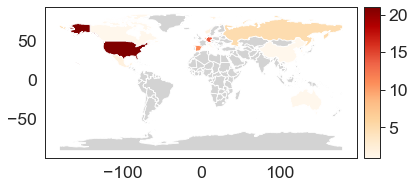

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

plot_world = mapped.plot(column='Count',ax=ax, legend=True, cax=cax, cmap=cmap, vmin= 1)
plot_world.figure.savefig('../reports/figures/surveys_per_country.png')

### Survey Operator

In [34]:
data.groupby("survey_operator").size().sort_values(ascending = False)

survey_operator
Author                                                                                                                                 14
Netquest                                                                                                                               12
CentERdata                                                                                                                              8
Online Market Intelligence                                                                                                              5
KnowledgePanel                                                                                                                          3
GESIS                                                                                                                                   3
German Longitudinal Election Study                                                                                                      3
SurveyMonkey Audie

### Data Quality

In [35]:
def create_data_set(df, topic):
    interesting_columns = ["survey_year","survey_participants_number",
                           "survey_country", "survey_operator",
                           "survey_population","survey_design_mobile_adapted", ]
    interesting_columns.append(topic)
    df_columns = df[interesting_columns]
    df_of_interest = df_columns[df_columns[topic].notna()]
    write_location = "../data/processed/" + topic + ".xlsx"
    df_of_interest.to_excel(write_location, index=False)
    return df_of_interest

#### Analyse Quality Dimensions

In [36]:
import re

In [37]:
quality_indicator = [x for x in data.columns.tolist() if re.match("mobile_(?!participant|design).*", x)] 
quality_indicator.sort()

In [38]:
data[quality_indicator].count().sort_values(ascending = False).head(10)

mobile_completion_time_higher         28
mobile_breakoff_rate_higher           15
mobile_missing_items_rate_higher      11
mobile_text_answer_shorter            11
mobile_text_answer_avoid_more          9
mobile_straightlining_more             6
mobile_non_substantial_anwser_more     5
mobile_primacy_effect_higher           4
mobile_satisfaction_lower              4
mobile_completion_rate_lower           4
dtype: int64

#### Analyze Completion Time

In [39]:
completion_time = create_data_set(data, "mobile_completion_time_higher")

In [40]:
def analyse_dimension(data, topic):
    print("Summary of the hypothesis decisions")
    print(data.groupby(topic).size())
    print("\n")
    print("Summary of the influence of the survey country")
    print(pd.crosstab(data['survey_country'],data[topic],margins = False))
    print("\n")
    print("Summary of the influence of the survey operator")
    print(pd.crosstab(data['survey_operator'],data[topic],margins = False))
    print("\n")
    print("Summary of the influence of the survey year")
    print(pd.crosstab(data['survey_year'],data[topic],margins = False))
    print("\n")
    print("Summary of the influence of an design adapted for mobile devices")
    print(pd.crosstab(data['survey_design_mobile_adapted'],data[topic],margins = False))
    print("\n")
    print("Summary of the influence of the survey population")
    print(pd.crosstab(data['survey_population'],data[topic],margins = False))
    print("\n")

In [41]:
analyse_dimension(completion_time, "mobile_completion_time_higher")

Summary of the hypothesis decisions
mobile_completion_time_higher
False             7
True             20
[True, False]     1
dtype: int64


Summary of the influence of the survey country
mobile_completion_time_higher  False  True  [True, False]
survey_country                                           
Germany                            0     4              0
Netherlands                        1     4              0
Norway                             0     1              0
Russia                             0     2              0
South Korea                        1     0              0
Spain                              1     3              0
USA                                4     6              0
['China', 'USA']                   0     0              1


Summary of the influence of the survey operator
mobile_completion_time_higher                       False  True  [True, False]
survey_operator                                                               
Amazon Mechanical Turk  

#### Break off rate

In [42]:
breakoff_rate = create_data_set(data, "mobile_breakoff_rate_higher")

In [43]:
analyse_dimension(breakoff_rate, "mobile_breakoff_rate_higher")

Summary of the hypothesis decisions
mobile_breakoff_rate_higher
0.0     3
1.0    12
dtype: int64


Summary of the influence of the survey country
mobile_breakoff_rate_higher   0.0  1.0
survey_country                        
Germany                         1    2
Netherlands                     1    0
Norwegia                        0    1
Russia                          0    3
South Korea                     1    0
UK                              0    1
USA                             0    4
['UK', 'Australia', 'Canda']    0    1


Summary of the influence of the survey operator
mobile_breakoff_rate_higher                         0.0  1.0
survey_operator                                             
Amazon Mechanical Turk                                0    1
Author                                                2    0
Dongguk University Student Life Survey                1    0
EuroQoL Research Foundation                           0    1
German Longitudinal Election Study              

#### Analyze Missing items Rate

In [44]:
missing_items = create_data_set(data, "mobile_missing_items_rate_higher")

In [45]:
analyse_dimension(missing_items, "mobile_missing_items_rate_higher")

Summary of the hypothesis decisions
mobile_missing_items_rate_higher
0.0    5
1.0    6
dtype: int64


Summary of the influence of the survey country
mobile_missing_items_rate_higher  0.0  1.0
survey_country                            
Germany                             0    2
Netherlands                         0    2
South Korea                         1    0
Spain                               1    1
UK                                  1    0
USA                                 2    1


Summary of the influence of the survey operator
mobile_missing_items_rate_higher            0.0  1.0
survey_operator                                     
Amazon Mechanical Turk                        0    1
Author                                        1    0
CentERdata                                    0    1
Dongguk University Student Life Survey        1    0
GESIS                                         0    2
Improving General Practice Service Survey     1    0
KnowledgePanel                   

#### Analyze Text Answer shorter

In [46]:
short_text = create_data_set(data, "mobile_text_answer_shorter")

In [47]:
analyse_dimension(short_text, "mobile_text_answer_shorter")

Summary of the hypothesis decisions
mobile_text_answer_shorter
False            3
True             7
[None, False]    1
dtype: int64


Summary of the influence of the survey country
mobile_text_answer_shorter  False  True  [None, False]
survey_country                                        
Germany                         1     1              0
Netherlands                     1     1              0
Russia                          0     1              0
Spain                           0     1              0
USA                             1     3              0
['China', 'USA']                0     0              1


Summary of the influence of the survey operator
mobile_text_answer_shorter                          False  True  [None, False]
survey_operator                                                               
Amazon Mechanical Turk                                  0     1              0
Author                                                  2     0              0
CentERdata  

#### Analyze Avoid Text Answer

In [48]:
avoid_text = create_data_set(data, "mobile_text_answer_avoid_more")

In [49]:
analyse_dimension(avoid_text, "mobile_text_answer_avoid_more")

Summary of the hypothesis decisions
mobile_text_answer_avoid_more
0.0    6
1.0    3
dtype: int64


Summary of the influence of the survey country
mobile_text_answer_avoid_more  0.0  1.0
survey_country                         
Germany                          1    1
Netherlands                      3    0
Spain                            1    0
UK                               0    1
USA                              1    1


Summary of the influence of the survey operator
mobile_text_answer_avoid_more              0.0  1.0
survey_operator                                    
Author                                       2    1
CentERdata                                   2    0
GESIS                                        0    1
Improving General Practice Service Survey    0    1
KnowledgePanel                               1    0
Netquest                                     1    0


Summary of the influence of the survey year
mobile_text_answer_avoid_more  0.0  1.0
survey_year           

#### Analyze Straightlining

In [50]:
straightlining = create_data_set(data, "mobile_straightlining_more")

In [51]:
analyse_dimension(straightlining, "mobile_straightlining_more")

Summary of the hypothesis decisions
mobile_straightlining_more
0.0    4
1.0    2
dtype: int64


Summary of the influence of the survey country
mobile_straightlining_more  0.0  1.0
survey_country                      
Germany                       0    1
Netherlands                   1    0
Russia                        1    0
UK                            1    0
USA                           1    1


Summary of the influence of the survey operator
mobile_straightlining_more                 0.0  1.0
survey_operator                                    
Amazon Mechanical Turk                       0    1
Author                                       1    0
GESIS                                        0    1
I&O Research Panel                           1    0
Improving General Practice Service Survey    1    0
Online Market Intelligence                   1    0


Summary of the influence of the survey year
mobile_straightlining_more  0.0  1.0
survey_year                         
2014.0      

### Survey Participants

In [52]:
participants_indicator = [x for x in data.columns.tolist() if re.match("mobile_participants_.*", x)] 
participants_indicator.sort()
data[participants_indicator].count().sort_values(ascending = False).head(60)

mobile_participants_younger                                          11
mobile_participants_more_female                                      10
mobile_participants_education_higher                                  6
mobile_participants_more_mobile                                       5
mobile_participants_income_higher                                     3
mobile_participants_less_alone                                        3
mobile_participants_more_male                                         2
mobile_participants_more_urban                                        2
mobile_participants_more_multitasking                                 2
mobile_participants_coverage_bias                                     2
mobile_participants_less_trust_in_confidentiality                     2
mobile_participants_social_class_higher                               1
mobile_participants_sensitivity_perceived_higher                      1
mobile_participants_representative_not                          

In [53]:
participants_indicator

['mobile_participants_coverage_bias',
 'mobile_participants_coverage_bias_weighting_elimated',
 'mobile_participants_education_higher',
 'mobile_participants_education_lower',
 'mobile_participants_income_higher',
 'mobile_participants_income_lower',
 'mobile_participants_less_alone',
 'mobile_participants_less_trust_in_confidentiality',
 'mobile_participants_millenial_willing_to_use_emoji',
 'mobile_participants_millenials_participate_more_mobile',
 'mobile_participants_more_distracted',
 'mobile_participants_more_female',
 'mobile_participants_more_male',
 'mobile_participants_more_mobile',
 'mobile_participants_more_moving',
 'mobile_participants_more_multitasking',
 'mobile_participants_more_progressive',
 'mobile_participants_more_stranger_present',
 'mobile_participants_more_urban',
 'mobile_participants_more_willing_passive_data_collection',
 'mobile_participants_multiple_browser_sessions_more',
 'mobile_participants_positive_asylum_decision_higher_participation',
 'mobile_parti

#### Age of Mobile Participants

In [54]:
younger = create_data_set(data, "mobile_participants_younger")

In [55]:
analyse_dimension(younger, "mobile_participants_younger")

Summary of the hypothesis decisions
mobile_participants_younger
False                 1
True                  8
[True, True, True]    1
[True, True]          1
dtype: int64


Summary of the influence of the survey country
mobile_participants_younger   False  True  [True, True, True]  [True, True]
survey_country                                                             
Germany                           0     2                   0             0
Netherlands                       0     3                   0             0
Norway                            0     1                   0             0
Norwegia                          0     1                   0             0
USA                               1     1                   0             0
['China', 'USA']                  0     0                   0             1
['UK', 'Australia', 'Canda']      0     0                   1             0


Summary of the influence of the survey operator
mobile_participants_younger                 

#### Gender of Participants

In [56]:
more_male = create_data_set(data, "mobile_participants_more_male")

In [57]:
analyse_dimension(more_male, "mobile_participants_more_male")

Summary of the hypothesis decisions
mobile_participants_more_male
1.0    2
dtype: int64


Summary of the influence of the survey country
mobile_participants_more_male  1.0
survey_country                    
Netherlands                      1
Norwegia                         1


Summary of the influence of the survey operator
mobile_participants_more_male  1.0
survey_operator                   
CentERdata                       1
Norwegian Citizen Panel Wave     1


Summary of the influence of the survey year
mobile_participants_more_male  1.0
survey_year                       
2012.0                           1
2016.0                           1


Summary of the influence of an design adapted for mobile devices
mobile_participants_more_male  1.0
survey_design_mobile_adapted      
True                             1


Summary of the influence of the survey population
mobile_participants_more_male  1.0
survey_population                 
Dutch-speaking Adults            1
Norwegian Adults  

In [58]:
more_female = create_data_set(data, "mobile_participants_more_female")

In [59]:
analyse_dimension(more_female, "mobile_participants_more_female")

Summary of the hypothesis decisions
mobile_participants_more_female
False                  3
True                   5
[True, False]          1
[True, True, False]    1
dtype: int64


Summary of the influence of the survey country
mobile_participants_more_female  False  True  [True, False]  \
survey_country                                                
Germany                              2     0              0   
Netherlands                          1     1              0   
Norway                               0     1              0   
USA                                  0     3              0   
['China', 'USA']                     0     0              1   
['UK', 'Australia', 'Canda']         0     0              0   

mobile_participants_more_female  [True, True, False]  
survey_country                                        
Germany                                            0  
Netherlands                                        0  
Norway                                       

#### Education

In [60]:
education_higher = create_data_set(data, "mobile_participants_education_higher")

In [61]:
analyse_dimension(education_higher, "mobile_participants_education_higher")

Summary of the hypothesis decisions
mobile_participants_education_higher
0.0    4
1.0    2
dtype: int64


Summary of the influence of the survey country
mobile_participants_education_higher  0.0  1.0
survey_country                                
Germany                                 1    0
Netherlands                             2    1
Norway                                  1    0
USA                                     0    1


Summary of the influence of the survey operator
mobile_participants_education_higher  0.0  1.0
survey_operator                               
Amazon Mechanical Turk                  0    1
Author                                  1    0
CentERdata                              1    1
German Longitudinal Election Study      1    0
Kantar TNS                              1    0


Summary of the influence of the survey year
mobile_participants_education_higher  0.0  1.0
survey_year                                   
2012.0                                  2    1

#### Mobility

In [62]:
more_mobile = create_data_set(data, "mobile_participants_more_mobile")

In [63]:
analyse_dimension(more_mobile, "mobile_participants_more_mobile")

Summary of the hypothesis decisions
mobile_participants_more_mobile
0.0    2
1.0    3
dtype: int64


Summary of the influence of the survey country
mobile_participants_more_mobile  0.0  1.0
survey_country                           
Netherlands                        1    1
Russia                             0    2
Spain                              1    0


Summary of the influence of the survey operator
mobile_participants_more_mobile  0.0  1.0
survey_operator                          
CentERdata                         1    1
Netquest                           1    0
Online Market Intelligence         0    2


Summary of the influence of the survey year
mobile_participants_more_mobile  0.0  1.0
survey_year                              
2011.0                             0    1
2012.0                             1    1
2013.0                             0    1
2015.0                             1    0


Summary of the influence of an design adapted for mobile devices
mobile_participan

#### Online Participants

In [64]:
online_participants_indicator = [x for x in data.columns.tolist() if re.match("online_participants_.*", x)]
online_participants_indicator.sort()

In [65]:
data[online_participants_indicator].count().sort_values(ascending = False)

online_participants_young_use_mobile_more                            2
online_participants_mobile_increasing                                2
online_participants_female_use_mobile_more                           1
online_participants_female_willingness_use_mobile_higher             1
online_participants_older_people_use_mobile_less                     1
online_participants_not_accepting_mobile_survey_older                1
online_participants_more_urban_use_mobile_more                       1
online_participants_more_educated_use_smartphone_more                1
online_participants_male_more_mobile_than_female                     1
online_participants_male_more_ios_than_female                        1
online_participants_male_more_android_than_female                    1
online_participants_lower_income_use_mobile_more                     1
online_participants_insights                                         1
online_participants_increasing_usage_of_smartphone                   1
online

In [66]:
data

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Place,Editor,Conference Name,article_name,...,mobile_design_emoji_request_decreases_completion_time,mobile_design_emoji_request_less_complex_survey,mobile_construct_validity,invitation_mode_rdd_sms_response_rate_low,mobile_participants_representative_not,mobile_participants_income_lower,mobile_participants_education_lower,mobile_scale_effects_more,mobile_design_measurement_invariance_decremental_scale,mobile_design_measurement_invariance_incremental_scale
0,journalArticle,2017,"Revilla, Melanie; Toninelli, Daniele; Ochoa, C...",An experiment comparing grids and item-by-item...,Telematics & Informatics,NaN,NaN,NaN,NaN,An experiment comparing grids and item-by-item...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,journalArticle,2019,"Bosch, Oriol J.; Revilla, Melanie; Paura, Ezeq...",Answering Mobile Surveys With Images: An Explo...,Social Science Computer Review,NaN,NaN,NaN,NaN,Answering Mobile Surveys With Images: An Explo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,journalArticle,2019,"Ha, Louisa,; Zhang, Chenjie",Are computers better than smartphones for web ...,Online Information Review,NaN,NaN,NaN,NaN,Are computers better than smartphones for web ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,journalArticle,2015,"Buskirk, Trent D.",Are sliders too slick for surveys? An experime...,"methods, data, analyses",NaN,NaN,NaN,NaN,Are sliders too slick for surveys? An experime...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,journalArticle,2017,"Revilla, Melanie",Are There Differences Depending on the Device ...,Field methods,NaN,NaN,NaN,NaN,Are There Differences Depending on the Device ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,journalArticle,2019,"Grady, Rebecca H.; Greenspan, Rachel L.; Liu, ...",What Is the Best Size for Matrix-Style Questio...,Social Science Computer Review,NaN,NaN,NaN,NaN,What Is the Best Size for Matrix-Style Questio...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,journalArticle,2015,"Wells, Tom",What market researchers should know about mobi...,International Journal of Market Research,NaN,NaN,NaN,NaN,What market researchers should know about mobi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,journalArticle,2015,"Steinbrecher, Markus; Roßmann, Joss; Blumensti...",Why Do Respondents Break Off Web Surveys and D...,International Journal of Public Opinion Research,NaN,NaN,NaN,NaN,Why Do Respondents Break Off Web Surveys and D...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,journalArticle,2017,"Couper, Mick P.; Peterson, Gregg J.",Why Do Web Surveys Take Longer on Smartphones?,Social Science Computer Review,NaN,NaN,NaN,NaN,Why Do Web Surveys Take Longer on Smartphones?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
online_participants_indicator

['online_participants_female_use_mobile_more',
 'online_participants_female_willingness_use_mobile_higher',
 'online_participants_higher_educated_willingness_use_mobile_higher',
 'online_participants_higher_education_use_mobile_more',
 'online_participants_higher_income_willingness_use_mobile_higher',
 'online_participants_increasing_usage_of_smartphone',
 'online_participants_insights',
 'online_participants_lower_income_use_mobile_more',
 'online_participants_male_more_android_than_female',
 'online_participants_male_more_ios_than_female',
 'online_participants_male_more_mobile_than_female ',
 'online_participants_mobile_increasing',
 'online_participants_more_educated_use_smartphone_more',
 'online_participants_more_urban_use_mobile_more',
 'online_participants_not_accepting_mobile_survey_older',
 'online_participants_older_people_use_mobile_less',
 'online_participants_young_use_mobile_more',
 'online_participants_younger_willingness_use_mobile_higher']

### Survey Design

In [68]:
design_dimensions = [x for x in data.columns.tolist() if re.match("mobile_design_.*", x)] 
design_dimensions.sort()
data[design_dimensions].count().sort_values(ascending = False).head(60)

mobile_design_paging_longer_completion_time_than_scrolling                                         2
mobile_design_recommendations                                                                      2
mobile_design_grid_versus_item_by_item_completion_time_shorter                                     2
mobile_design_next_bottom_always_visible_lower_completion_time_than_not_always_visible             1
mobile_design_optimized_letter_means_higher_reponses                                               1
mobile_design_paging_lower_satisfaction_than_scrolling                                             1
mobile_design_paging_lower_item_nonreponse_than_scrolling                                          1
mobile_design_paging_longer_completion_time_subjective_than_scrolling                              1
mobile_design_paging_higher_primacy_effect_than_scrolling                                          1
mobile_design_paging_higher_item_nonresponse_than_scrolling                                

In [69]:
design_dimensions

['mobile_design_agree_disagree_shorter_completion_time_than_item_specific_question',
 'mobile_design_always_on_next_button_data_quality_difference_to_two_columns',
 'mobile_design_android_spinner_higher_satisfaction_than_radio_botton',
 'mobile_design_android_spinner_longer_completion_time_than_radio_botton',
 'mobile_design_android_spinner_lower_accuracy_than_radio_botton',
 'mobile_design_date_picker_anwser_less_accurate',
 'mobile_design_date_picker_less_successful_answers',
 'mobile_design_emoji_different_mean_rating',
 'mobile_design_emoji_different_satisfaction',
 'mobile_design_emoji_preference_differs_between_countries',
 'mobile_design_emoji_request_decreases_completion_time',
 'mobile_design_emoji_request_increase_informatio_conveyed',
 'mobile_design_emoji_request_less_complex_survey',
 'mobile_design_emoji_usage_differs_between_countries',
 'mobile_design_grid_versus_item_by_item_anwser_change_more',
 'mobile_design_grid_versus_item_by_item_completion_time_shorter',
 'mobil

In [70]:
invitation_mode = [x for x in data.columns.tolist() if re.match("invitation_mode_.*", x)] 
invitation_mode.sort()
data[invitation_mode].count().sort_values(ascending = False).head(60)

invitation_mode_breakoff_rate_sms_invitation_higher                                  3
invitation_mode_mobile_reponse_rate_sms_invitation_higher                            2
invitation_mode_mobile_reponse_time_sms_invitation_shorter_than_e_mail_invitation    2
invitation_mode_mobile_participants_rate_sms_invitation_higher                       1
invitation_mode_mobile_reponse_time_after_reminder_faster                            1
invitation_mode_rdd_sms_response_rate_low                                            1
invitation_mode_sms_inivitation_higher_mobile_participation                          0
invitation_mode_sms_invitation_mobile_breakoff_rate_higher                           0
dtype: int64

In [71]:
invitation_mode

['invitation_mode_breakoff_rate_sms_invitation_higher',
 'invitation_mode_mobile_participants_rate_sms_invitation_higher',
 'invitation_mode_mobile_reponse_rate_sms_invitation_higher',
 'invitation_mode_mobile_reponse_time_after_reminder_faster',
 'invitation_mode_mobile_reponse_time_sms_invitation_shorter_than_e_mail_invitation',
 'invitation_mode_rdd_sms_response_rate_low',
 'invitation_mode_sms_inivitation_higher_mobile_participation',
 'invitation_mode_sms_invitation_mobile_breakoff_rate_higher']

### Alternative Input Mode

In [91]:
def get_results(df, columns):
    interesting_columns = ["survey_year","survey_participants_number",
                           "survey_country", "survey_operator",
                           "survey_population","survey_design_mobile_adapted", ]
    df_columns = df[interesting_columns + columns]
    df_of_interest = df_columns[df_columns[alternative_input].notna().any(axis = 1)]
    return df_of_interest

In [92]:
get_results(data, alternative_input)

,survey_year,survey_participants_number,survey_country,survey_operator,survey_population,survey_design_mobile_adapted,input_alternative_android_voice_higher_nonreponse_than_text,input_alternative_android_voice_less_valid_answers_than_text,input_alternative_android_voice_more_characters_than_text,input_alternative_android_voice_more_complicated_than_text,...,input_alternative_ios_voice_less_characters_than_text,input_alternative_ios_voice_less_valid_answers_than_text,input_alternative_ios_voice_more_complicated_than_text,input_alternative_ios_voice_trust_anonymity_less_than_text,input_alternative_messenger_completion_rate_lower,input_alternative_messenger_completion_time_longer,input_alternative_messenger_shorter_text,input_alternative_not_clear_reasons_for_non_compliance_images,input_alternative_voice_different_instruction_reduce_technical_problems,input_alternative_voice_faster_per_character_than_text
1,2017.0,1614,"['Spain', 'Mexico']",Netquest,Millenials (16-34) with Smartphone,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
37,2019.0,1860,Spain,Netquest,Spainish People (16+) with Android,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
56,2018.0,1728,USA,Amazon Mechanical Turk,American Adults,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN
68,2018.0,1205,Spain,Netquest,Adults with Smartphone,True,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
alternative_input = [x for x in data.columns.tolist() if re.match("input_alternativ.*", x)] 
alternative_input.sort()
data[alternative_input].count().sort_values(ascending = False).head(60)

In [73]:
alternative_input

['input_alternative_android_voice_higher_nonreponse_than_text',
 'input_alternative_android_voice_less_valid_answers_than_text',
 'input_alternative_android_voice_more_characters_than_text',
 'input_alternative_android_voice_more_complicated_than_text',
 'input_alternative_android_voice_more_techical_problems_than_text',
 'input_alternative_android_voice_trust_anonymity_less_than_text',
 'input_alternative_image_taking_lower_compliance_than_image_uploading',
 'input_alternative_ios_voice_higher_nonreponse_than_text',
 'input_alternative_ios_voice_less_characters_than_text',
 'input_alternative_ios_voice_less_valid_answers_than_text',
 'input_alternative_ios_voice_more_complicated_than_text',
 'input_alternative_ios_voice_trust_anonymity_less_than_text',
 'input_alternative_messenger_completion_rate_lower',
 'input_alternative_messenger_completion_time_longer',
 'input_alternative_messenger_shorter_text',
 'input_alternative_not_clear_reasons_for_non_compliance_images',
 'input_alternat

In [74]:
paradata_input = [x for x in data.columns.tolist() if re.match("paradata_.*", x)] 
paradata_input.sort()
data[paradata_input].count().sort_values(ascending = False).head(60)

paradata_higher_motion_means_higher_completion_time_if_grid               1
paradata_higher_motion_means_higher_completion_time_if_single_question    1
paradata_higher_motion_means_higher_primacy_effect_if_grid                1
paradata_higher_motion_means_higher_primacy_effect_if_single_question     1
paradata_standing_less_extreme_values_than_walking                        1
paradata_standing_less_primacy_more_than_walking                          1
paradata_standing_more_middle_values_than_walking                         1
paradata_standing_more_recency_than_walking                               1
paradata_standing_motion_compliance_more_than_walking                     1
dtype: int64

In [75]:
paradata_input

['paradata_higher_motion_means_higher_completion_time_if_grid',
 'paradata_higher_motion_means_higher_completion_time_if_single_question',
 'paradata_higher_motion_means_higher_primacy_effect_if_grid',
 'paradata_higher_motion_means_higher_primacy_effect_if_single_question',
 'paradata_standing_less_extreme_values_than_walking',
 'paradata_standing_less_primacy_more_than_walking',
 'paradata_standing_more_middle_values_than_walking',
 'paradata_standing_more_recency_than_walking',
 'paradata_standing_motion_compliance_more_than_walking']

### Discussion

In [76]:
other_topics = [x for x in data.columns.tolist() if re.match("^(?!mobile|input|invitation|online|paradata).*", x)] 
other_topics.sort()
data[other_topics].count().sort_values(ascending = False).head(60)

Author                                86
Item Type                             86
Publication Year                      86
Title                                 86
Publication Title                     84
article_name                          82
article_topic                         82
article_type                          82
survey_data                           81
survey_participants_number            73
survey_country                        71
survey_mode                           71
survey_population                     70
survey_operator                       70
survey_participants_representative    67
survey_year                           62
survey_year_detail                    62
survey_design_mobile_adapted          48
survey_participants_number_mobile     25
survey_participants_source            18
survey_incentive                       9
review_mobile_design                   5
participants_incentivized              2
review_data_quality                    2
Place           

In [77]:
other_topics

['Author',
 'Conference Name',
 'Editor',
 'Item Type',
 'Place',
 'Publication Title',
 'Publication Year',
 'Publisher',
 'Title',
 'article_name',
 'article_topic',
 'article_type',
 'participants_incentivized',
 'quality_geometric_mean',
 'quality_no_outlier_deleted',
 'review_current_research',
 'review_data_quality',
 'review_mobile_design',
 'review_mobile_participants',
 'review_summarizes_existing_results',
 'survey_country',
 'survey_data',
 'survey_data_from_another_survey',
 'survey_design_mobile_adapted',
 'survey_incentive',
 'survey_invitation_mode',
 'survey_mode',
 'survey_number_inivitations',
 'survey_operator',
 'survey_participants_number',
 'survey_participants_number_mobile',
 'survey_participants_representative',
 'survey_participants_source',
 'survey_population',
 'survey_year',
 'survey_year_detail']